In [1]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from spring_rods_system_setup import SpringRodsSystemSetup
from spring_rods_system_with_penalization_setup import SpringRodSystemWithPenalizationSetup
from spring_rods_system_solver import SpringRodsSystemSolver
from utils.computational_utils import l2_norm
from utils.plot_utils import plot_displacements_and_stress

In [2]:
plt.rcParams.update({
    'axes.grid': True,
    'figure.facecolor': 'white',
    'mathtext.default': 'regular',
    'figure.figsize': (6, 4)
})

In [3]:
model_setup = {
    'interval': (-1, 1),
    'spring_len': 1,
    'step_size': 1/256,
    'material_const': (1, 1),
    'spring_const': (1, 1),
}

In [4]:
def penalize_compression_func(x: Tuple[np.ndarray, np.ndarray]):
    spring_len = model_setup['spring_len']
    theta = spring_len - x[0][-1] + x[1][0]
    # This is specific for looking for a solution with assumption of spring compression
    if theta >= spring_len:
        return 0
    return (spring_len - theta) ** 2


def penalize_extension_func(x: Tuple[np.ndarray, np.ndarray]):
    spring_len = model_setup['spring_len']
    theta = spring_len - x[0][-1] + x[1][0]
    # This is specific for looking for a solution with assumption of spring extension
    if theta <= spring_len:
        return 0
    return (spring_len - theta) ** 2

In [5]:
experiment_definitions = [
    {
        'body_forces': lambda x: np.where(x < 0, 1, -1), # forces that causes compression
        'penalization_func': penalize_compression_func,
        'spring_len_bounds':(-np.inf, 0) # the constraint that doesn't allow the spring to compress
    },
    {
        'body_forces': lambda x: np.where(x < 0, -1, 1), # forces that causes extension
        'penalization_func': penalize_extension_func,
        'spring_len_bounds':(0, model_setup['spring_len']) # the constraint that doesn't allow the spring to extend
    }
]

In [6]:
experiment_idx = 1
experiment_setup = experiment_definitions[experiment_idx - 1]

In [7]:
model = SpringRodsSystemSetup(
    **model_setup,
    body_forces=experiment_setup['body_forces']
)
solver = SpringRodsSystemSolver(
    model,
    spring_len_bounds=experiment_setup['spring_len_bounds']
)
constrained_solution = solver()

In [8]:
penalized_model = SpringRodSystemWithPenalizationSetup(
    **model_setup,
    body_forces=experiment_setup['body_forces'],
    penalization_function=experiment_setup['penalization_func'],
    penalization_const=1 # this is going to be overwritten
)
solver = SpringRodsSystemSolver(penalized_model)

In [9]:
# inverse_penal_params = np.array([1 / (1 << x) for x in range(4, 0, -1)] + [1 << x for x in range(14)])

param_powers = np.arange(3, -14, -1)
penal_params = np.power(2., param_powers)
penal_params_labels = [f'$2^{{{q}}}$' for q in param_powers]

In [10]:
print(penal_params)
print(penal_params_labels)

[8.00000000e+00 4.00000000e+00 2.00000000e+00 1.00000000e+00
 5.00000000e-01 2.50000000e-01 1.25000000e-01 6.25000000e-02
 3.12500000e-02 1.56250000e-02 7.81250000e-03 3.90625000e-03
 1.95312500e-03 9.76562500e-04 4.88281250e-04 2.44140625e-04
 1.22070312e-04]
['$2^{3}$', '$2^{2}$', '$2^{1}$', '$2^{0}$', '$2^{-1}$', '$2^{-2}$', '$2^{-3}$', '$2^{-4}$', '$2^{-5}$', '$2^{-6}$', '$2^{-7}$', '$2^{-8}$', '$2^{-9}$', '$2^{-10}$', '$2^{-11}$', '$2^{-12}$', '$2^{-13}$']


In [11]:
cmap = plt.get_cmap('viridis', penal_params.size)

17it [01:27,  5.15s/it]


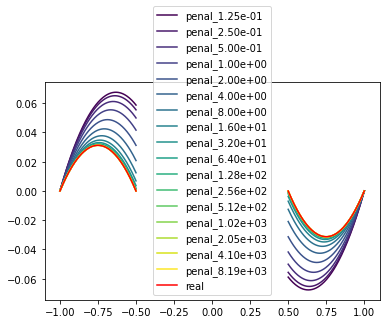

In [12]:
displacement = []
stress = []
error_norm = []
spring_ends = []

for idx, penal in tqdm(enumerate(penal_params)):
    penalized_model.penalization_const = penal
    solution = solver()

    displacement.append(solution)
    stress.append(solver.compute_stresses(solution))

    err = tuple(solution[side] - constrained_solution[side] for side in (0, 1))
    error_norm.append(l2_norm(values=err, domain=model.domain))

    spring_ends.append((solution[0][-1], solution[1][0]))

    plt.plot(penalized_model.domain[0], solution[0], color=cmap(idx), label=f'penal_{1 / penal:.2e}')
    plt.plot(penalized_model.domain[1], solution[1], color=cmap(idx))

plt.plot(model.domain[0], constrained_solution[0], color='red', label='real')
plt.plot(model.domain[1], constrained_solution[1], color='red')

plt.legend()
plt.grid()

In [13]:
param_x_ticks = np.linspace(0, len(penal_params) - 1, 9, dtype=int)

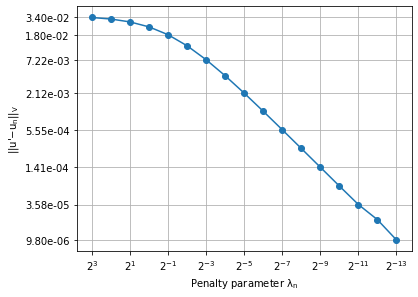

In [14]:
fig = plt.gcf()
fig.set_size_inches((6, 4.5))

plt.plot(penal_params, error_norm, marker='o')
plt.xlabel('Penalty parameter $\lambda_n$')
target_sign = "'" if experiment_idx == 1 else "''"
plt.ylabel(f'$||u${target_sign}$ - u_n||_V$')
plt.xscale('log')
plt.yscale('log')

plt.minorticks_off()
plt.xticks(penal_params[param_x_ticks], np.array(penal_params_labels)[param_x_ticks])

plt.gca().invert_xaxis()
yticks = np.delete(error_norm[::2], 1)
plt.yticks(yticks, [f'{err:.2e}' for err in yticks])
plt.savefig(f'plots/convergence_results/convergence_error_norm_{experiment_idx}.png', bbox_inches='tight')

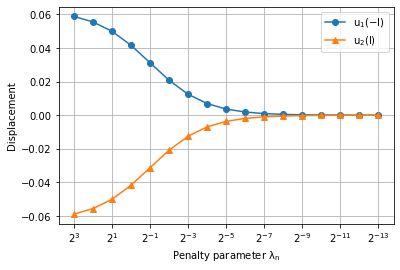

In [15]:
plt.plot([s[0] for s in spring_ends], label='$u_1(-l)$', marker='o')
plt.plot([s[1] for s in spring_ends], label='$u_2(l)$', marker='^')

plt.xticks(param_x_ticks, np.array(penal_params_labels)[param_x_ticks])

plt.xlabel('Penalty parameter $\lambda_n$')
plt.ylabel('Displacement')
plt.legend()
plt.savefig(f'plots/convergence_results/convergence_spring_ends_{experiment_idx}.png', bbox_inches='tight')

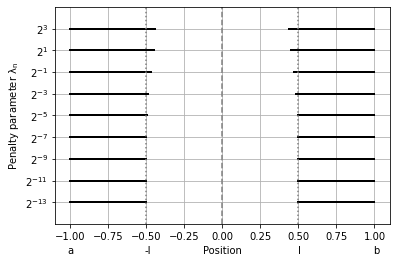

In [16]:
up_limit = 0.4
down_limit = -0.4
assert np.max(np.concatenate(stress)) < up_limit and np.min(np.concatenate(stress)) > down_limit

plot_displacements_and_stress(model, zip(displacement[::2], stress[::2]), penal_params_labels[::2], 'Penalty parameter $\lambda_n$', (down_limit, up_limit), f'plots/convergence_results/convergence_displacement_{experiment_idx}.png')

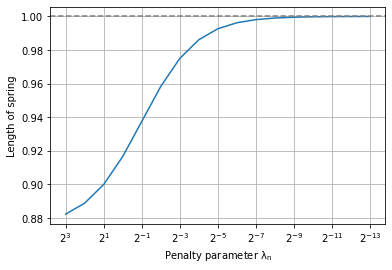

In [17]:
plt.plot([model.spring_len - s[0] + s[1] for s in spring_ends])

plt.xticks(param_x_ticks, np.array(penal_params_labels)[param_x_ticks])

plt.axhline(y=model.spring_len, color='gray', linestyle='--')

plt.xlabel('Penalty parameter $\lambda_n$')
plt.ylabel('Length of spring')
plt.savefig(f'plots/convergence_results/convergence_spring_length_{experiment_idx}.png', bbox_inches='tight')